In [1]:
!pip install torch
!pip install datasets
!pip install tokenizers
!pip install torchmetrics
!pip install lightning
!pip install pytorch_lightning

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
from torchsummary import summary


# Setting Device

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Loading Dataset

In [4]:
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

# Variational Autoencoder for MNIST

In [5]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()

        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc11 = nn.Linear(10, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)

    def encoder(self, x, label_one_hot):
        h0 = F.relu(self.fc1(x))
        h1 = F.relu(self.fc11(label_one_hot))
        h2 = torch.add(h0, h1)
        h = F.relu(self.fc2(h2))
        return self.fc31(h), self.fc32(h) # mu, log_var

    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample

    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        h = F.sigmoid(self.fc6(h))
        return h

    def forward(self, x, label_one_hot):
        mu, log_var = self.encoder(x.view(-1, 784), label_one_hot)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# Model Summary

In [6]:
model= VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    model.cuda()

summary(model.to(device), [(784,), (10,)], batch_size=-1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 512]           5,632
            Linear-3                  [-1, 256]         131,328
            Linear-4                    [-1, 2]             514
            Linear-5                    [-1, 2]             514
            Linear-6                  [-1, 256]             768
            Linear-7                  [-1, 512]         131,584
            Linear-8                  [-1, 784]         402,192
Total params: 1,074,452
Trainable params: 1,074,452
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.02
Params size (MB): 4.10
Estimated Total Size (MB): 4.15
----------------------------------------------------------------


# Train and Test the Model

In [7]:
optimizer = optim.Adam(model.parameters())

def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# model train
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.float().cuda()
        label_one_hot = F.one_hot(label, 10).float().cuda()
        optimizer.zero_grad()

        recon_batch, mu, log_var = model(data, label_one_hot)
        loss = loss_function(recon_batch, data, mu, log_var)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Train Epoch: {} Training loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

# Model Test
def test():
    model.eval()
    test_loss= 0
    with torch.no_grad():
        for data, label in test_loader:
            data = data.float().cuda()
            label_one_hot = F.one_hot(label, 10).float().cuda()
            recon, mu, log_var = model(data, label_one_hot)

            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(0, 40):
    train(epoch + 1)
    test()

====> Train Epoch: 1 Training loss: 193.9672
====> Test set loss: 168.1934
====> Train Epoch: 2 Training loss: 164.0557
====> Test set loss: 161.0329
====> Train Epoch: 3 Training loss: 157.7967
====> Test set loss: 156.6617
====> Train Epoch: 4 Training loss: 153.9481
====> Test set loss: 153.6557
====> Train Epoch: 5 Training loss: 151.3479
====> Test set loss: 151.4085
====> Train Epoch: 6 Training loss: 149.3918
====> Test set loss: 149.6487
====> Train Epoch: 7 Training loss: 147.8557
====> Test set loss: 148.1694
====> Train Epoch: 8 Training loss: 146.6952
====> Test set loss: 147.4382
====> Train Epoch: 9 Training loss: 145.7374
====> Test set loss: 147.0555
====> Train Epoch: 10 Training loss: 144.9814
====> Test set loss: 146.2487
====> Train Epoch: 11 Training loss: 144.3298
====> Test set loss: 145.6633
====> Train Epoch: 12 Training loss: 143.6630
====> Test set loss: 144.8411
====> Train Epoch: 13 Training loss: 143.1945
====> Test set loss: 144.6262
====> Train Epoch: 14

# Model Evaluation

In [8]:
import random
import matplotlib.pyplot as plt
import torch

model.eval()

with torch.no_grad():
    i = 0
    for data, label in val_loader:
        i += 1
        if i > 0:
            break

val_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=25, shuffle=False)
model.eval()

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc11): Linear(in_features=10, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

# 25 MNIST outputs PROPERLY Labelled and 25 MNIST Incorrectly Labelled

Correct Labels:
Sample 1: Actual Label: 7 Given Label: 7
Sample 2: Actual Label: 2 Given Label: 2
Sample 3: Actual Label: 1 Given Label: 1
Sample 4: Actual Label: 0 Given Label: 0
Sample 5: Actual Label: 4 Given Label: 4
Sample 6: Actual Label: 1 Given Label: 1
Sample 7: Actual Label: 4 Given Label: 4
Sample 8: Actual Label: 9 Given Label: 9
Sample 9: Actual Label: 5 Given Label: 5
Sample 10: Actual Label: 9 Given Label: 9
Sample 11: Actual Label: 0 Given Label: 0
Sample 12: Actual Label: 6 Given Label: 6
Sample 13: Actual Label: 9 Given Label: 9
Sample 14: Actual Label: 0 Given Label: 0
Sample 15: Actual Label: 1 Given Label: 1
Sample 16: Actual Label: 5 Given Label: 5
Sample 17: Actual Label: 9 Given Label: 9
Sample 18: Actual Label: 7 Given Label: 7
Sample 19: Actual Label: 3 Given Label: 3
Sample 20: Actual Label: 4 Given Label: 4
Sample 21: Actual Label: 9 Given Label: 9
Sample 22: Actual Label: 6 Given Label: 6
Sample 23: Actual Label: 6 Given Label: 6
Sample 24: Actual Label: 5 

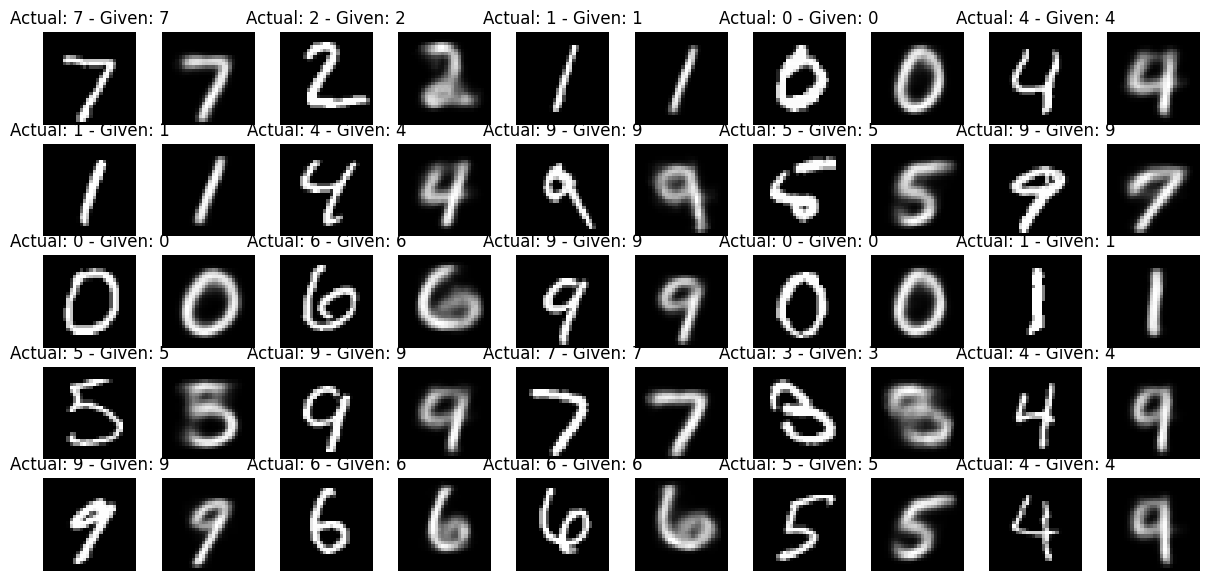

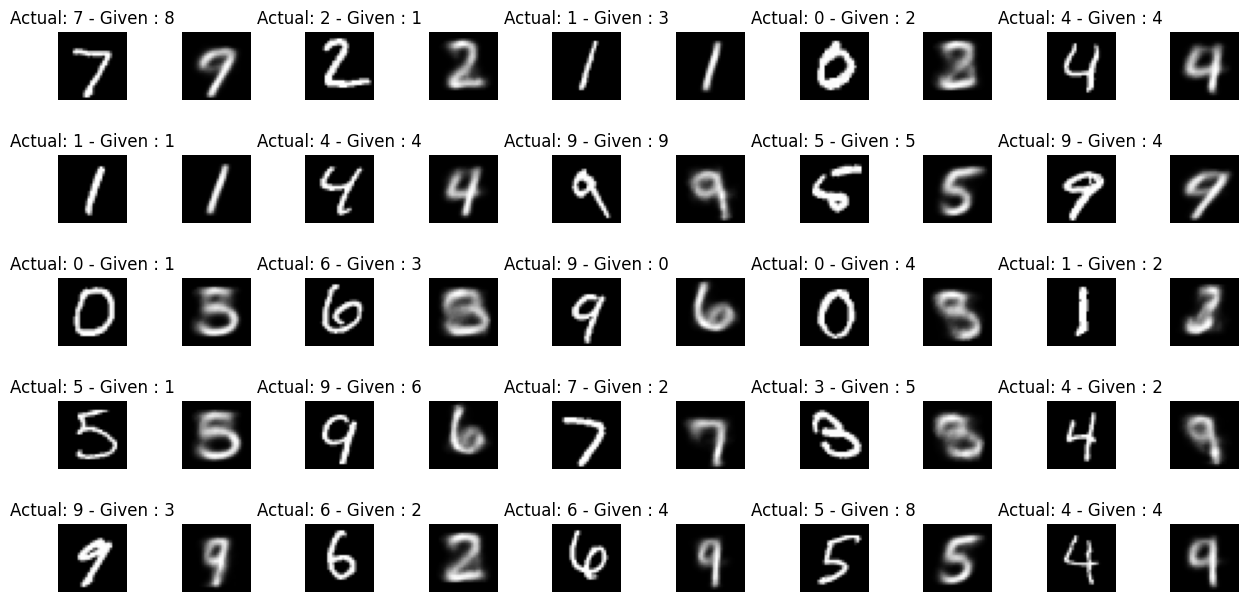

In [9]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def visualize_original_and_predicted_images_with_labels(model, val_loader):
    model.eval()

    with torch.no_grad():
        i = 0
        for data, label in val_loader:
            i += 1
            if i > 0:
                break

    # Initialize lists to store original and predicted images for correct and incorrect labels
    original_images_correct = []
    predicted_images_correct = []
    original_images_incorrect = []
    predicted_images_incorrect = []

    data = data.float().cuda()
    label_one_hot_val = F.one_hot(label, 10).float().cuda()

    recon_val, mu_val, log_var_val = model(data, label_one_hot_val)

    print("Correct Labels:")
    for d in range(25):
        # Append the original and predicted images to the lists for correct labels
        original_images_correct.append(data[d][0].cpu().numpy())
        predicted_images_correct.append(recon_val.view(25, 1, 28, 28)[d].detach().cpu().numpy())
        print(f"Sample {d + 1}: Actual Label: {label[d]} Given Label: {label[d]}")  # Include both actual and given labels

        # Check if predicted image has a valid shape for correct labels
        if predicted_images_correct[d][0].shape != (28, 28):
            print(f"Warning: Invalid shape for predicted image {d + 1}")

    # Create a new tensor with random values of the same type
    false_label = torch.randint_like(label, low=0, high=10)  # Generates random integers between 0 and 9
    false_label_one_hot_val = F.one_hot(false_label, 10).float().cuda()

    recon_val, mu_val, log_var_val = model(data, false_label_one_hot_val)

    print("\nIncorrect Labels:")
    for d in range(25):
        # Append the original and predicted images to the lists for incorrect labels
        original_images_incorrect.append(data[d][0].cpu().numpy())
        predicted_images_incorrect.append(recon_val.view(25, 1, 28, 28)[d].detach().cpu().numpy())
        print(f"Sample {d + 1}: Actual Label: {label[d]} Given Label: {false_label[d]}")

        # Check if predicted image has a valid shape for incorrect labels
        if predicted_images_incorrect[d][0].shape != (28, 28):
            print(f"Warning: Invalid shape for predicted image {d + 1}")

    # Create figures to display both sets of images
    fig_correct, axes_correct = plt.subplots(5, 10, figsize=(15, 7))
    fig_incorrect, axes_incorrect = plt.subplots(5, 10, figsize=(15, 7))

    # Adjust the spacing between subplots for both figures
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.8)

    for i in range(25):
        row = i // 5
        col = i % 5

        # Show original images with correct labels
        axes_correct[row, col * 2].imshow(original_images_correct[i].reshape(28, 28), cmap='gray')
        axes_correct[row, col * 2].set_title(f"Actual: {label[i]} - Given: {label[i]}")  # Include both actual and given labels

        # Check if predicted image has a valid shape for correct labels
        if predicted_images_correct[i][0].shape == (28, 28):
            axes_correct[row, col * 2 + 1].imshow(predicted_images_correct[i][0], cmap='gray')
        else:
            axes_correct[row, col * 2 + 1].set_title("Invalid Shape")

        # Show original images with incorrect labels
        axes_incorrect[row, col * 2].imshow(original_images_incorrect[i].reshape(28, 28), cmap='gray')
        axes_incorrect[row, col * 2].set_title(f"Actual: {label[i]} - Given : {false_label[i]}")

        # Check if predicted image has a valid shape for incorrect labels
        if predicted_images_incorrect[i][0].shape == (28, 28):
            axes_incorrect[row, col * 2 + 1].imshow(predicted_images_incorrect[i][0], cmap='gray')
        else:
            axes_incorrect[row, col * 2 + 1].set_title("Invalid Shape")

    # Remove axis labels from all subplots for both figures
    for ax in axes_correct.flatten():
        ax.axis('off')
    for ax in axes_incorrect.flatten():
        ax.axis('off')

    plt.show()

visualize_original_and_predicted_images_with_labels(model, val_loader)